In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

## for Procrustes analysis
from scipy.spatial import procrustes 

## for principal component analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

## for linear discriminant analysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn import datasets

## suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
## define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
## and p1 being the left hand of the angle and p3 a reference point for directionality
## inputs: three angle points, as tuples
## output: angle in degrees

def AngleBetween(p1, p2, p3):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

## define a function to rotate 2D x and y coordinate points around the origin
## inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
## target_angle is the angle you want to rotate to, in degrees
## outputs: rotated and y vals

def RotatePoints(xvals, yvals, degrees, target_angle):
    
    angle_to_move = target_angle - degrees 
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals

# Import maracuyá data and reassign landmark identities. Reflect data to create a whole leaf (not just one side)

In [6]:
## read in data
maracuyá_data = pd.read_csv("./procrustes_landmarks.csv")

## calculate relative node
maracuyá_data["rel_node"] = maracuyá_data["ontogeny"] / maracuyá_data["total"]

## get landmarks for the right side (when leaf is facing down)
## see Figure 1 at https://doi.org/10.1093/gigascience/giw008 for landmarks
## rename landmarks A-F (base to tip)
right_cols = ["plant","species","x1","y1","x7","y7","x8","y8","x9","y9","x10","y10","x11","y11","rel_node"]
right_side = maracuyá_data.loc[:,right_cols]
right_side.columns = ["plant","species","xA","yA","xB","yB","xC","yC","xD","yD","xE","yE","xF","yF","rel_node"]

## select desired angle to rotate to
desired_ang = 270

## create empty array to store rotated data
maracuya_arr = np.zeros((len(right_side),22))

## for each leaf rotate and then reflect points
## >3000 leaves to process
for i in range(len(right_side)):
    
    ## print every 1000 iterations
    if i%1000==0:
        print(i)

    ## select current leaf
    curr_leaf = right_side.loc[i, :]
    
    ## translate petiolar junction to origin
    curr_leaf["xA"] = curr_leaf["xA"]-curr_leaf["xA"]
    curr_leaf["xB"] = curr_leaf["xB"]-curr_leaf["xA"]
    curr_leaf["xC"] = curr_leaf["xC"]-curr_leaf["xA"]
    curr_leaf["xD"] = curr_leaf["xD"]-curr_leaf["xA"]
    curr_leaf["xE"] = curr_leaf["xE"]-curr_leaf["xA"]
    curr_leaf["xF"] = curr_leaf["xF"]-curr_leaf["xA"]
    
    curr_leaf["yA"] = curr_leaf["yA"]-curr_leaf["yA"]
    curr_leaf["yB"] = curr_leaf["yB"]-curr_leaf["yA"]
    curr_leaf["yC"] = curr_leaf["yC"]-curr_leaf["yA"]
    curr_leaf["yD"] = curr_leaf["yD"]-curr_leaf["yA"]
    curr_leaf["yE"] = curr_leaf["yE"]-curr_leaf["yA"]
    curr_leaf["yF"] = curr_leaf["yF"]-curr_leaf["yA"]

    ## get the angle between the tip and the base of the leaf
    curr_ang = AngleBetween(
        (curr_leaf["xF"],curr_leaf["yF"]),
        (curr_leaf["xA"],curr_leaf["yA"]),
        (curr_leaf["xA"]+1,curr_leaf["yA"]))

    ## rotate points to the desired angle
    new_leaf = RotatePoints(
        np.array(curr_leaf[["xA","xB","xC","xD","xE","xF"]]),
        np.array(curr_leaf[["yA","yB","yC","yD","yE","yF"]]),
        curr_ang,
        desired_ang)

    ## store the rotated points
    maracuya_arr[i,:] = np.array(
        (new_leaf[0][0], new_leaf[1][0],
        new_leaf[0][1], new_leaf[1][1],
        new_leaf[0][2], new_leaf[1][2],
        new_leaf[0][3], new_leaf[1][3],
        new_leaf[0][4], new_leaf[1][4],
        new_leaf[0][5], new_leaf[1][5],
        -new_leaf[0][4], new_leaf[1][4],
        -new_leaf[0][3], new_leaf[1][3],
        -new_leaf[0][2], new_leaf[1][2],
        -new_leaf[0][1], new_leaf[1][1],
        new_leaf[0][0], new_leaf[1][0]
        ))
   
## create a new pandas dataframe
reflect_maracuya = pd.DataFrame({
    "dataset":"maracuya",
    "plant":right_side["plant"],
    "species":right_side["species"],
    "rel_node":right_side["rel_node"],
    "xA":maracuya_arr[:,0],
    "yA":maracuya_arr[:,1],
    "xB":maracuya_arr[:,2],
    "yB":maracuya_arr[:,3],
    "xC":maracuya_arr[:,4],
    "yC":maracuya_arr[:,5],
    "xD":maracuya_arr[:,6],
    "yD":maracuya_arr[:,7],
    "xE":maracuya_arr[:,8],
    "yE":maracuya_arr[:,9],
    "xF":maracuya_arr[:,10],
    "yF":maracuya_arr[:,11],
    "xG":maracuya_arr[:,12],
    "yG":maracuya_arr[:,13],
    "xH":maracuya_arr[:,14],
    "yH":maracuya_arr[:,15],
    "xI":maracuya_arr[:,16],
    "yI":maracuya_arr[:,17],
    "xJ":maracuya_arr[:,18],
    "yJ":maracuya_arr[:,19],
    "xK":maracuya_arr[:,20],
    "yK":maracuya_arr[:,20]})

0
1000
2000
3000


0
1000
2000
3000


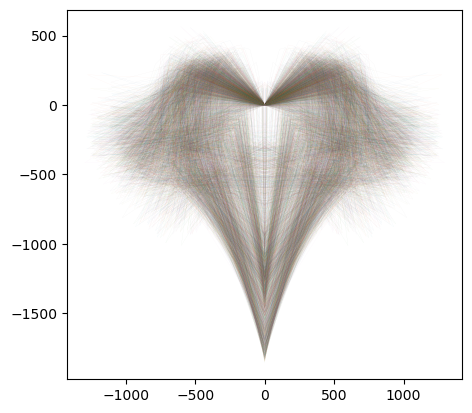

In [7]:
## plot maracuyá leaves to check
for i in range(len(reflect_maracuya)):
    
    if i%1000==0:
        print(i)
    
    curr_xvals = reflect_maracuya.loc[i,["xA","xB","xC","xD","xE","xF","xG","xH","xI","xJ","xK"]]
    curr_yvals = reflect_maracuya.loc[i,["yA","yB","yC","yD","yE","yF","yG","yH","yI","yJ","yK"]]
    
    plt.plot(curr_xvals, curr_yvals, lw=0.1, alpha=0.1)
    plt.gca().set_aspect("equal")

# Import grapevine data and reassign landmark identities. Reflect data to create a whole leaf (not just one side)

In [8]:
## read in grape data
grape_data = pd.read_csv("./grapevine_landmarks.csv")

## grape data
grape_cols = ["vine_year","species","x1","y1","x15","y15","x16","y16","x18","y18","x19","y19","x21","y21","heteroblasty"]
grape_df = grape_data.loc[:,grape_cols]
grape_df.columns = ["plant","species","xA","yA","xB","yB","xC","yC","xD","yD","xE","yE","xF","yF","rel_node"]
grape_df["dataset"] = "grapevine"

## create empty array to store rotated data
grape_arr = np.zeros((len(grape_df),22))

## for each leaf rotate and then reflect points
## >8000 leaves to process
for i in range(len(grape_df)):
    
    ## print every 1000 iterations
    if i%1000==0:
        print(i)

    ## select current leaf
    curr_leaf = grape_df.loc[i, :]
    
    ## translate petiolar junction to origin
    curr_leaf["xA"] = curr_leaf["xA"]-curr_leaf["xA"]
    curr_leaf["xB"] = curr_leaf["xB"]-curr_leaf["xA"]
    curr_leaf["xC"] = curr_leaf["xC"]-curr_leaf["xA"]
    curr_leaf["xD"] = curr_leaf["xD"]-curr_leaf["xA"]
    curr_leaf["xE"] = curr_leaf["xE"]-curr_leaf["xA"]
    curr_leaf["xF"] = curr_leaf["xF"]-curr_leaf["xA"]
    
    curr_leaf["yA"] = curr_leaf["yA"]-curr_leaf["yA"]
    curr_leaf["yB"] = curr_leaf["yB"]-curr_leaf["yA"]
    curr_leaf["yC"] = curr_leaf["yC"]-curr_leaf["yA"]
    curr_leaf["yD"] = curr_leaf["yD"]-curr_leaf["yA"]
    curr_leaf["yE"] = curr_leaf["yE"]-curr_leaf["yA"]
    curr_leaf["yF"] = curr_leaf["yF"]-curr_leaf["yA"]

    ## get the angle between the tip and the base of the leaf
    curr_ang = AngleBetween(
        (curr_leaf["xF"],curr_leaf["yF"]),
        (curr_leaf["xA"],curr_leaf["yA"]),
        (curr_leaf["xA"]+1,curr_leaf["yA"]))

    ## rotate points to the desired angle
    new_leaf = RotatePoints(
        np.array(curr_leaf[["xA","xB","xC","xD","xE","xF"]]),
        np.array(curr_leaf[["yA","yB","yC","yD","yE","yF"]]),
        curr_ang,
        desired_ang)
    
    ## store the rotated points
    grape_arr[i,:] = np.array(
        (new_leaf[0][0], new_leaf[1][0],
        new_leaf[0][1], new_leaf[1][1],
        new_leaf[0][2], new_leaf[1][2],
        new_leaf[0][3], new_leaf[1][3],
        new_leaf[0][4], new_leaf[1][4],
        new_leaf[0][5], new_leaf[1][5],
        -new_leaf[0][4], new_leaf[1][4],
        -new_leaf[0][3], new_leaf[1][3],
        -new_leaf[0][2], new_leaf[1][2],
        -new_leaf[0][1], new_leaf[1][1],
        new_leaf[0][0], new_leaf[1][0]))
   
## create a new pandas dataframe
reflect_grapevine = pd.DataFrame({
    "dataset":"grapevine",
    "plant":grape_df["plant"],
    "species":grape_df["species"],
    "rel_node":grape_df["rel_node"],
    "xA":grape_arr[:,0],
    "yA":grape_arr[:,1],
    "xB":grape_arr[:,2],
    "yB":grape_arr[:,3],
    "xC":grape_arr[:,4],
    "yC":grape_arr[:,5],
    "xD":grape_arr[:,6],
    "yD":grape_arr[:,7],
    "xE":grape_arr[:,8],
    "yE":grape_arr[:,9],
    "xF":grape_arr[:,10],
    "yF":grape_arr[:,11],
    "xG":grape_arr[:,12],
    "yG":grape_arr[:,13],
    "xH":grape_arr[:,14],
    "yH":grape_arr[:,15],
    "xI":grape_arr[:,16],
    "yI":grape_arr[:,17],
    "xJ":grape_arr[:,18],
    "yJ":grape_arr[:,19],
    "xK":grape_arr[:,20],
    "yK":grape_arr[:,21]})



0
1000
2000
3000
4000
5000
6000
7000
8000


0
1000
2000
3000
4000
5000
6000
7000
8000


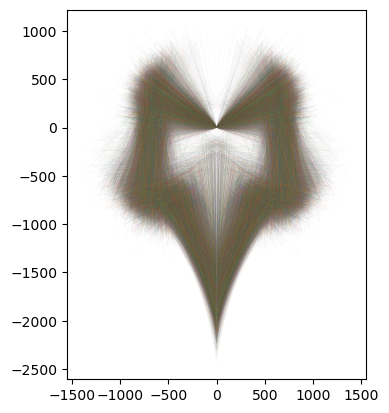

In [9]:
## plot grapevine leaves to check
for i in range(len(reflect_grapevine)):
    
    if i%1000==0:
        print(i)
    
    curr_xvals = reflect_grapevine.loc[i,["xA","xB","xC","xD","xE","xF","xG","xH","xI","xJ","xK"]]
    curr_yvals = reflect_grapevine.loc[i,["yA","yB","yC","yD","yE","yF","yG","yH","yI","yJ","yK"]]
    
    plt.plot(curr_xvals, curr_yvals, lw=0.1, alpha=0.1)
    plt.gca().set_aspect("equal")

# Create combined maracuyá and grapevine dataset

In [10]:
## create a combined df with muracuyá and grapevine data
combined_df = pd.concat([reflect_maracuya, reflect_grapevine], ignore_index=True, axis=0)


In [11]:
## array to store landmark data
combined_arr = np.zeros((len(combined_df),11,2))

## loop over each leaf
## >11,000 leaves
for i in range(len(combined_df)):
    
    if i%1000 == 0:
        print(i)

    ## use .loc to get df data
    ## use np. array to transform into an array
    ## use reshape to reshape the array
    ## place the landmark data into combined_arr
    combined_arr[i,:,:] = np.reshape(np.array(combined_df.loc[i,[
                                            "xA","yA",
                                            "xB","yB",
                                            "xC","yC",
                                            "xD","yD",
                                            "xE","yE",
                                            "xF","yF",
                                            "xG","yG",
                                            "xH","yH",
                                            "xI","yI",
                                            "xJ","yJ",
                                            "xK","yK"]]),
                           (11,2)) ## reshape

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000


# Perform Procrustes analysis to align all leaves to each other

In [12]:
## select a reference shape
ref_ind = 0 
ref_shape = combined_arr[ref_ind] # select the reference shape

## get number of landmarks from first shape (it's the same for all shapes)
landmark_number = np.shape(combined_arr[0])[0] 

## set a Procrustes distance between means to stop the algorithm, arbitrarily small
mean_diff = 10**(-30) 

## for the first comparison between means, set old_mean to an arbitrary reference shape
old_mean = ref_shape 

## set d, the distance, initially arbitraily high
d = 1000000 

## set boolean criterion for Procrustes distance between mean to stop calculations
while d > mean_diff: 
    
    ## empty 3D array: # samples, total number of landmarks, 2 coord vals
    arr = np.zeros( ((len(combined_arr)),landmark_number,2) ) 

    ## for each leaf shape
    for i in range(len(combined_arr)):  

        ## calculate procrustes adjusted shape to ref for current leaf
        s1, s2, distance = procrustes(old_mean, combined_arr[i]) 
        
        ## store procrustes adjusted shape to array
        arr[i] = s2 

    ## calculate mean of all shapes adjusted to reference
    new_mean = np.mean(arr, axis=(0)) 
    
    ## calculate procrustes distance of new mean to old mean
    s1, s2, d = procrustes(old_mean, new_mean) 
    
    ## print out difference between mean distance
    print("the Procrustes distance between the old and new mean is", d) 
    
    ## set the old_mean to the new_mea before beginning another iteration
    old_mean = new_mean 

## call the resulting mean leaf "gpa_mean"
gpa_mean = new_mean 


the Procrustes distance between the old and new mean is 0.07592602523206247
the Procrustes distance between the old and new mean is 2.2754095262222823e-05
the Procrustes distance between the old and new mean is 8.878738966194216e-09
the Procrustes distance between the old and new mean is 4.1428282862053745e-12
the Procrustes distance between the old and new mean is 2.107267648737334e-15
the Procrustes distance between the old and new mean is 1.122232374770696e-18
the Procrustes distance between the old and new mean is 6.173248941509342e-22
the Procrustes distance between the old and new mean is 3.4818276537283457e-25
the Procrustes distance between the old and new mean is 1.9726561834445656e-28
the Procrustes distance between the old and new mean is 1.3233988838464982e-31


(-0.2978470610578053,
 0.29784706105780545,
 -0.5033346104907647,
 0.24357802372033618)

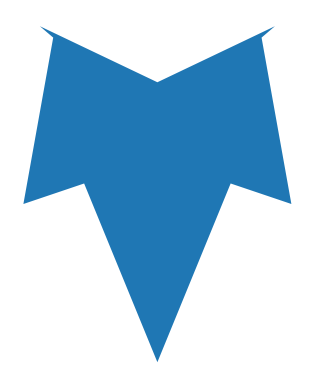

In [13]:
## plot generalized Procrustes mean shape to check
plt.fill(gpa_mean[:,0], gpa_mean[:,1])
plt.gca().set_aspect("equal")
plt.axis("off")

# Retrieve superimposed landmarks by aligning to the Procrustes mean

In [14]:
## get number of landmarks from first shape (it's the same for all)
landmark_number = np.shape(combined_arr[0])[0] 

## empty 3D array: # samples, total landmarks, 2 coord vals
proc_arr = np.zeros( ((len(combined_arr)), landmark_number, 2) ) 

## for each leaf shape 
for i in range(len(combined_arr)): 

    ## calculate procrustes adjusted shape to ref for current leaf
    s1, s2, distance = procrustes(gpa_mean, combined_arr[i]) 
    
    ## store procrustes adjusted shape to array
    proc_arr[i] = s2 

(-0.5406003480298329,
 0.5406003480298329,
 -0.7704681566450249,
 0.40067048620707024)

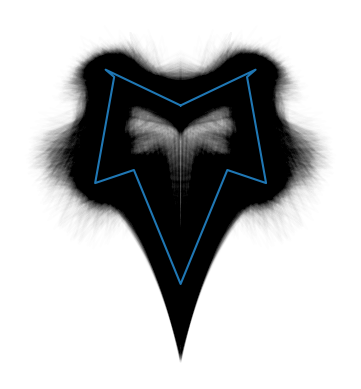

In [15]:
## plot out all Procrustes aligned leaves to check
plot_col = "k" # set plot color
a = 0.007 # set alpha

for i in range(np.shape(proc_arr)[0]):
    
    curr_leaf = proc_arr[i,:,:]
    
    ## plot current leaf with color and alpha
    plt.plot(curr_leaf[:,0], curr_leaf[:,1], c=plot_col, alpha=a) 
    plt.gca().set_aspect("equal")

## plot the mean leaf
plt.plot(gpa_mean[:,0], gpa_mean[:,1]) 

plt.gca().set_aspect("equal")
plt.axis("off")

# Principal Component Analysis, morphospace, and eigenleaf representations

In [16]:
## define number of desired PCs
## for reconstruction, it's easier to just use 2
## but we can use more PC values if desired

pca = PCA(n_components=2)

## apply the sklearn pca function with desired number of components

PCs = pca.fit_transform(np.reshape(proc_arr, (11784, 22)))


In [17]:
## define a function to plot background morphospace
## inputs: scale, determined by checking, to prevent shape overlap in the plot. 
## PC1_pad and PC2_pad, padding on each side of PC to add extra space to see morphospace
## num_intervals, number of intervals to divide each PC axis as a grid
## output: a morphospace plot

def Morphospace(scale, PC1_pad, PC2_pad, num_intervals, PCs):

    ## get PC1 interval values
    PC1_intervals = np.linspace( np.min(PCs[:,0]), np.max(PCs[:,0]) ,num_intervals)

    ## get PC2 interval values
    PC2_intervals = np.linspace( np.min(PCs[:,1]), np.max(PCs[:,1]), num_intervals)

    for i in PC1_intervals:

        for j in PC2_intervals:

            ## perform inverse PCA
            inv_new = pca.inverse_transform(np.array([i,j]))

            ## extract x and y vals, every other
            inv_PC1_vals = inv_new[0::2]
            inv_PC2_vals = inv_new[1::2]

            ## scale so the shapes don't overlap, determine the right scale by checking
            scaled_PC1_vals = inv_PC1_vals*scale
            scaled_PC2_vals = inv_PC2_vals*scale

            ## translate to the PCA point position
            trans_PC1_vals = scaled_PC1_vals + i
            trans_PC2_vals = scaled_PC2_vals + j

            ## plot out the results to make sure it is correct
            plt.fill(trans_PC1_vals, trans_PC2_vals, c="gray", alpha=0.3)
            plt.xlim( (np.min(PCs[:,0])-PC1_pad, np.max(PCs[:,0])+PC1_pad) )
            plt.ylim( (np.min(PCs[:,1])-PC2_pad, np.max(PCs[:,1])+PC2_pad) )
            plt.gca().set_aspect("equal")

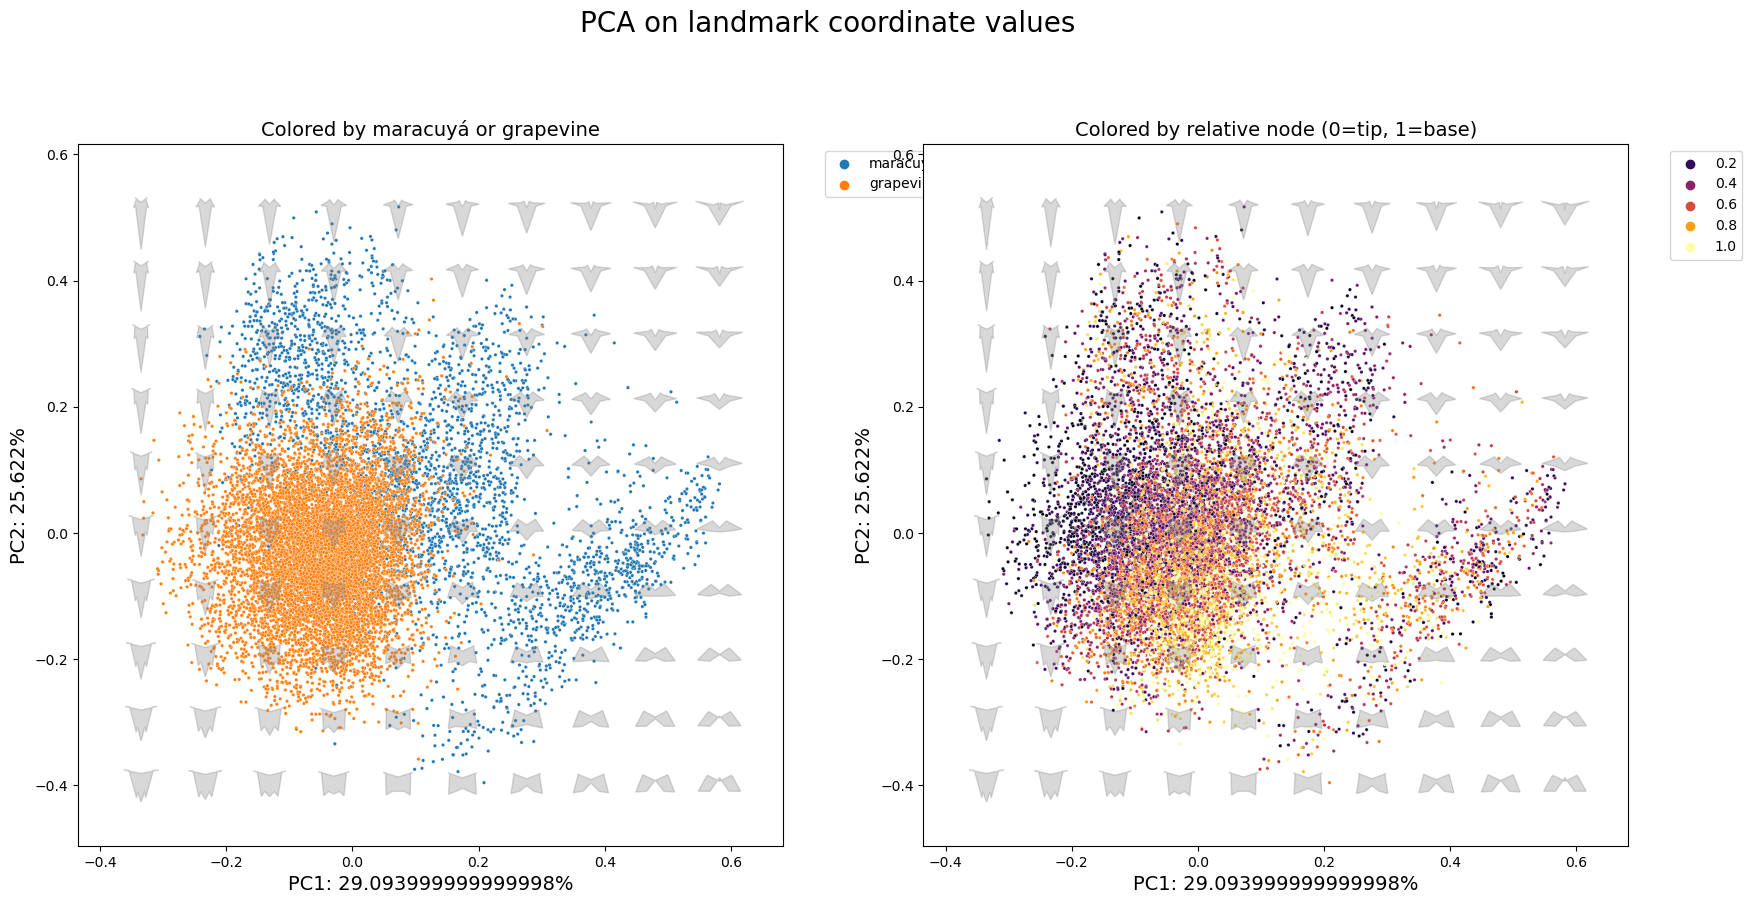

In [18]:
## create df to plot PCs
df = pd.DataFrame({"PC1":PCs[:,0], "PC2":PCs[:,1], "dataset":combined_df["dataset"], "rel_node":combined_df["rel_node"]})

## scale, determined by checking, to prevent shape overlap
scale = 0.07

## padding on each side of PC to add extra space to see morphospace
PC1_pad = 0.1
PC2_pad = 0.1

## number of intervals to divide each PC axis
num_intervals = 10

## fontsize
fs=14

## point size
ps = 6

## alpha
al = 1

plt.figure(figsize=(20,10))

#############
#############
#############

plt.subplot(1,2,1)
# scatterplot of PC values, colored by aspect ratio (using hue in seaborn)
sns.scatterplot(data=df, x="PC1", y="PC2", hue="dataset", s=ps, alpha=al)

# use the morphospace function to create morphospace
Morphospace(scale, PC1_pad, PC2_pad, num_intervals, PCs)

# place the legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left") # use loc="upper left" to move

# create axes label with principal component percent variance
plt.xlabel("PC1: "+ str( round(pca.explained_variance_ratio_[0],5)*100 ) + "%", fontsize=14)
plt.ylabel("PC2: "+ str( round(pca.explained_variance_ratio_[1],5)*100 ) + "%", fontsize=14)
plt.title("Colored by maracuyá or grapevine", fontsize=fs)

#############
#############
#############

plt.subplot(1,2,2)
# scatterplot of PC values, colored by aspect ratio (using hue in seaborn)
sns.scatterplot(data=df, x="PC1", y="PC2", hue="rel_node", s=ps, alpha=al, palette="inferno")

# use the morphospace function to create morphospace
Morphospace(scale, PC1_pad, PC2_pad, num_intervals, PCs)

# place the legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left") # use loc="upper left" to move

# create axes label with principal component percent variance
plt.xlabel("PC1: "+ str( round(pca.explained_variance_ratio_[0],5)*100 ) + "%", fontsize=14)
plt.ylabel("PC2: "+ str( round(pca.explained_variance_ratio_[1],5)*100 ) + "%", fontsize=14)
plt.title("Colored by relative node (0=tip, 1=base)", fontsize=fs)

plt.suptitle("PCA on landmark coordinate values", fontsize=fs+6)

# save figure
plt.savefig("leaf_PCA.jpg")


# 2nd degree polynomial models of development

In [16]:
## reshape the procrustes data to flatten the x and y coordinates
reshaped_proc_arr = np.reshape(proc_arr, (11784, 22))

## create a new dataframe with procrustes data
proc_df = pd.DataFrame({"plant":combined_df["plant"],
                        "species":combined_df["species"],
                        "dataset":combined_df["dataset"],
                        "rel_node":combined_df["rel_node"],
                        "xA":reshaped_proc_arr[:,0],
                        "yA":reshaped_proc_arr[:,1],
                        "xB":reshaped_proc_arr[:,2],
                        "yB":reshaped_proc_arr[:,3],
                        "xC":reshaped_proc_arr[:,4],
                        "yC":reshaped_proc_arr[:,5],
                        "xD":reshaped_proc_arr[:,6],
                        "yD":reshaped_proc_arr[:,7],
                        "xE":reshaped_proc_arr[:,8],
                        "yE":reshaped_proc_arr[:,9],
                        "xF":reshaped_proc_arr[:,10],
                        "yF":reshaped_proc_arr[:,11],
                        "xG":reshaped_proc_arr[:,12],
                        "yG":reshaped_proc_arr[:,13],
                        "xH":reshaped_proc_arr[:,14],
                        "yH":reshaped_proc_arr[:,15],
                        "xI":reshaped_proc_arr[:,16],
                        "yI":reshaped_proc_arr[:,17],
                        "xJ":reshaped_proc_arr[:,18],
                        "yJ":reshaped_proc_arr[:,19],
                        "xK":reshaped_proc_arr[:,20],
                        "yK":reshaped_proc_arr[:,21]
                       
                       })

## grapevine '597293x2017' only has 3 leaves
## and a model can not be fit
## it is removed
proc_df = proc_df[proc_df["plant"]!='597293x2017']


## create a list of unique plant/vine names
plants = proc_df["plant"].unique()


# Create separate polynomial models from tip to middle of shoot (ontogeny, "ont") and from base to middle of shoot (heteroblasty, "het")

In [17]:
## set degree of polynomial to model
degrees = 2

## set number of rows/samples (for ontogeny and heteroblasty separate)
vine_num = len(plants)
nrows = vine_num*2

## set number of columns
land_num = 11
coord_num = land_num*2
ncols = (degrees+1)*coord_num

## create array to store coefficients
coef_arr = np.zeros((nrows, ncols))

## create list to store datasets
dataset_list = []

## create list to store ont_het info
onthet_list = []

## create list to store interaction effect info
interaction_list = []

## >1000 plants
for i in range(len(plants)):
    
    if i%250==0:
        print(i)

    ## select current plant
    curr_plant = plants[i]
    
    ## save dataset info (append twice, because two models for each vine)
    dataset_list.append(np.array(proc_df["dataset"][proc_df["plant"]==curr_plant])[0])
    dataset_list.append(np.array(proc_df["dataset"][proc_df["plant"]==curr_plant])[0])
    
    ## ontogeny and heteroblasty info 
    onthet_list.append("ont")
    onthet_list.append("het")
    
    ## interaction info
    interaction_list.append( np.array(proc_df["dataset"][proc_df["plant"]==curr_plant])[0]+"_"+ "ont")
    interaction_list.append( np.array(proc_df["dataset"][proc_df["plant"]==curr_plant])[0]+"_"+ "het")
    
    ## create a dataframe for just the current plant
    curr_data = proc_df[proc_df["plant"]==curr_plant]

    ## calculate mean relative node number of current plant
    mean_node = curr_data["rel_node"].mean()

    ## create dataframes for ontogeny (from tip)
    ## and heteroblasty (from base)

    ont_data = curr_data[curr_data["rel_node"]<mean_node]
    het_data = curr_data[curr_data["rel_node"]>mean_node]

    ## renormalize to 0 and 1 relative node for
    ## ontogeny and heteroblasty

    ont_data["ont_rel_node"] =  (ont_data.loc[:,"rel_node"]) - (ont_data.loc[:,"rel_node"].min())
    ont_data["ont_rel_node"] = (ont_data.loc[:,"ont_rel_node"])/(ont_data.loc[:,"ont_rel_node"].max())

    het_data["het_rel_node"] =  -((het_data.loc[:,"rel_node"]) - (het_data.loc[:,"rel_node"].max()))
    het_data["het_rel_node"] = (het_data.loc[:,"het_rel_node"])/(het_data.loc[:,"het_rel_node"].max())

    ## CALCULATE COEFFICIENTS
    ## coefficient outputs are highest power first

    ## XA
    coef_arr[i*2,0:3] = np.polyfit(ont_data["ont_rel_node"], ont_data["xA"], deg=degrees)
    coef_arr[(i*2)+1,0:3] = np.polyfit(het_data["het_rel_node"], het_data["xA"], deg=degrees)

    ## YA
    coef_arr[i*2,3:6] = np.polyfit(ont_data["ont_rel_node"], ont_data["yA"], deg=degrees)
    coef_arr[(i*2)+1,3:6] = np.polyfit(het_data["het_rel_node"], het_data["yA"], deg=degrees)

    ## XB
    coef_arr[i*2,6:9] = np.polyfit(ont_data["ont_rel_node"], ont_data["xB"], deg=degrees)
    coef_arr[(i*2)+1,6:9] = np.polyfit(het_data["het_rel_node"], het_data["xB"], deg=degrees)

    ## YB
    coef_arr[i*2,9:12] = np.polyfit(ont_data["ont_rel_node"], ont_data["yB"], deg=degrees)
    coef_arr[(i*2)+1,9:12] = np.polyfit(het_data["het_rel_node"], het_data["yB"], deg=degrees)

    ## XC
    coef_arr[i*2,12:15] = np.polyfit(ont_data["ont_rel_node"], ont_data["xC"], deg=degrees)
    coef_arr[(i*2)+1,12:15] = np.polyfit(het_data["het_rel_node"], het_data["xC"], deg=degrees)

    ## YC
    coef_arr[i*2,15:18] = np.polyfit(ont_data["ont_rel_node"], ont_data["yC"], deg=degrees)
    coef_arr[(i*2)+1,15:18] = np.polyfit(het_data["het_rel_node"], het_data["yC"], deg=degrees)

    ## XD
    coef_arr[i*2,18:21] = np.polyfit(ont_data["ont_rel_node"], ont_data["xD"], deg=degrees)
    coef_arr[(i*2)+1,18:21] = np.polyfit(het_data["het_rel_node"], het_data["xD"], deg=degrees)

    ## YD
    coef_arr[i*2,21:24] = np.polyfit(ont_data["ont_rel_node"], ont_data["yD"], deg=degrees)
    coef_arr[(i*2)+1,21:24] = np.polyfit(het_data["het_rel_node"], het_data["yD"], deg=degrees)

    ## XE
    coef_arr[i*2,24:27] = np.polyfit(ont_data["ont_rel_node"], ont_data["xE"], deg=degrees)
    coef_arr[(i*2)+1,24:27] = np.polyfit(het_data["het_rel_node"], het_data["xE"], deg=degrees)

    ## YE
    coef_arr[i*2,27:30] = np.polyfit(ont_data["ont_rel_node"], ont_data["yE"], deg=degrees)
    coef_arr[(i*2)+1,27:30] = np.polyfit(het_data["het_rel_node"], het_data["yE"], deg=degrees)

    ## XF
    coef_arr[i*2,30:33] = np.polyfit(ont_data["ont_rel_node"], ont_data["xF"], deg=degrees)
    coef_arr[(i*2)+1,30:33] = np.polyfit(het_data["het_rel_node"], het_data["xF"], deg=degrees)

    ## YF
    coef_arr[i*2,33:36] = np.polyfit(ont_data["ont_rel_node"], ont_data["yF"], deg=degrees)
    coef_arr[(i*2)+1,33:36] = np.polyfit(het_data["het_rel_node"], het_data["yF"], deg=degrees)
    
    ## XG
    coef_arr[i*2,36:39] = np.polyfit(ont_data["ont_rel_node"], ont_data["xG"], deg=degrees)
    coef_arr[(i*2)+1,36:39] = np.polyfit(het_data["het_rel_node"], het_data["xG"], deg=degrees)

    ## YG
    coef_arr[i*2,39:42] = np.polyfit(ont_data["ont_rel_node"], ont_data["yG"], deg=degrees)
    coef_arr[(i*2)+1,39:42] = np.polyfit(het_data["het_rel_node"], het_data["yG"], deg=degrees)
    
    ## XH
    coef_arr[i*2,42:45] = np.polyfit(ont_data["ont_rel_node"], ont_data["xH"], deg=degrees)
    coef_arr[(i*2)+1,42:45] = np.polyfit(het_data["het_rel_node"], het_data["xH"], deg=degrees)

    ## YH
    coef_arr[i*2,45:48] = np.polyfit(ont_data["ont_rel_node"], ont_data["yH"], deg=degrees)
    coef_arr[(i*2)+1,45:48] = np.polyfit(het_data["het_rel_node"], het_data["yH"], deg=degrees)
    
    ## XI
    coef_arr[i*2,48:51] = np.polyfit(ont_data["ont_rel_node"], ont_data["xI"], deg=degrees)
    coef_arr[(i*2)+1,48:51] = np.polyfit(het_data["het_rel_node"], het_data["xI"], deg=degrees)

    ## YI
    coef_arr[i*2,51:54] = np.polyfit(ont_data["ont_rel_node"], ont_data["yI"], deg=degrees)
    coef_arr[(i*2)+1,51:54] = np.polyfit(het_data["het_rel_node"], het_data["yI"], deg=degrees)
    
    ## XJ
    coef_arr[i*2,54:57] = np.polyfit(ont_data["ont_rel_node"], ont_data["xJ"], deg=degrees)
    coef_arr[(i*2)+1,54:57] = np.polyfit(het_data["het_rel_node"], het_data["xJ"], deg=degrees)

    ## YJ
    coef_arr[i*2,57:60] = np.polyfit(ont_data["ont_rel_node"], ont_data["yJ"], deg=degrees)
    coef_arr[(i*2)+1,57:60] = np.polyfit(het_data["het_rel_node"], het_data["yJ"], deg=degrees)
    
    ## XK
    coef_arr[i*2,60:63] = np.polyfit(ont_data["ont_rel_node"], ont_data["xK"], deg=degrees)
    coef_arr[(i*2)+1,60:63] = np.polyfit(het_data["het_rel_node"], het_data["xK"], deg=degrees)

    ## YK
    coef_arr[i*2,63:66] = np.polyfit(ont_data["ont_rel_node"], ont_data["yK"], deg=degrees)
    coef_arr[(i*2)+1,63:66] = np.polyfit(het_data["het_rel_node"], het_data["yK"], deg=degrees)

0
250
500
750
1000


# Create dataframe of coefficient values for ont and het

In [18]:
## create column names
col_names = ["xA_a","xA_b","xA_c","yA_a","yA_b","yA_c",
             "xB_a","xB_b","xB_c","yB_a","yB_b","yB_c",
             "xC_a","xC_b","xC_c","yC_a","yC_b","yC_c",
             "xD_a","xD_b","xD_c","yD_a","yD_b","yD_c",
             "xE_a","xE_b","xE_c","yE_a","yE_b","yE_c",
             "xF_a","xF_b","xF_c","yF_a","yF_b","yF_c",
             "xG_a","xG_b","xG_c","yG_a","yG_b","yG_c",
             "xH_a","xH_b","xH_c","yH_a","yH_b","yH_c",
             "xI_a","xI_b","xI_c","yI_a","yI_b","yI_c",
             "xJ_a","xJ_b","xJ_c","yJ_a","yJ_b","yJ_c",
             "xK_a","xK_b","xK_c","yK_a","yK_b","yK_c"
            ]

## create pandas dataframe from array data
coef_df = pd.DataFrame(coef_arr, columns=col_names)

## add dataset and ont_het data to coef_df
coef_df["ont_het"] = onthet_list
coef_df["dataset"] = dataset_list
coef_df["interaction"] = interaction_list


# Plot in PCA space tip-to-middle line segments for ontogeny

0
200
400
600
800
1000


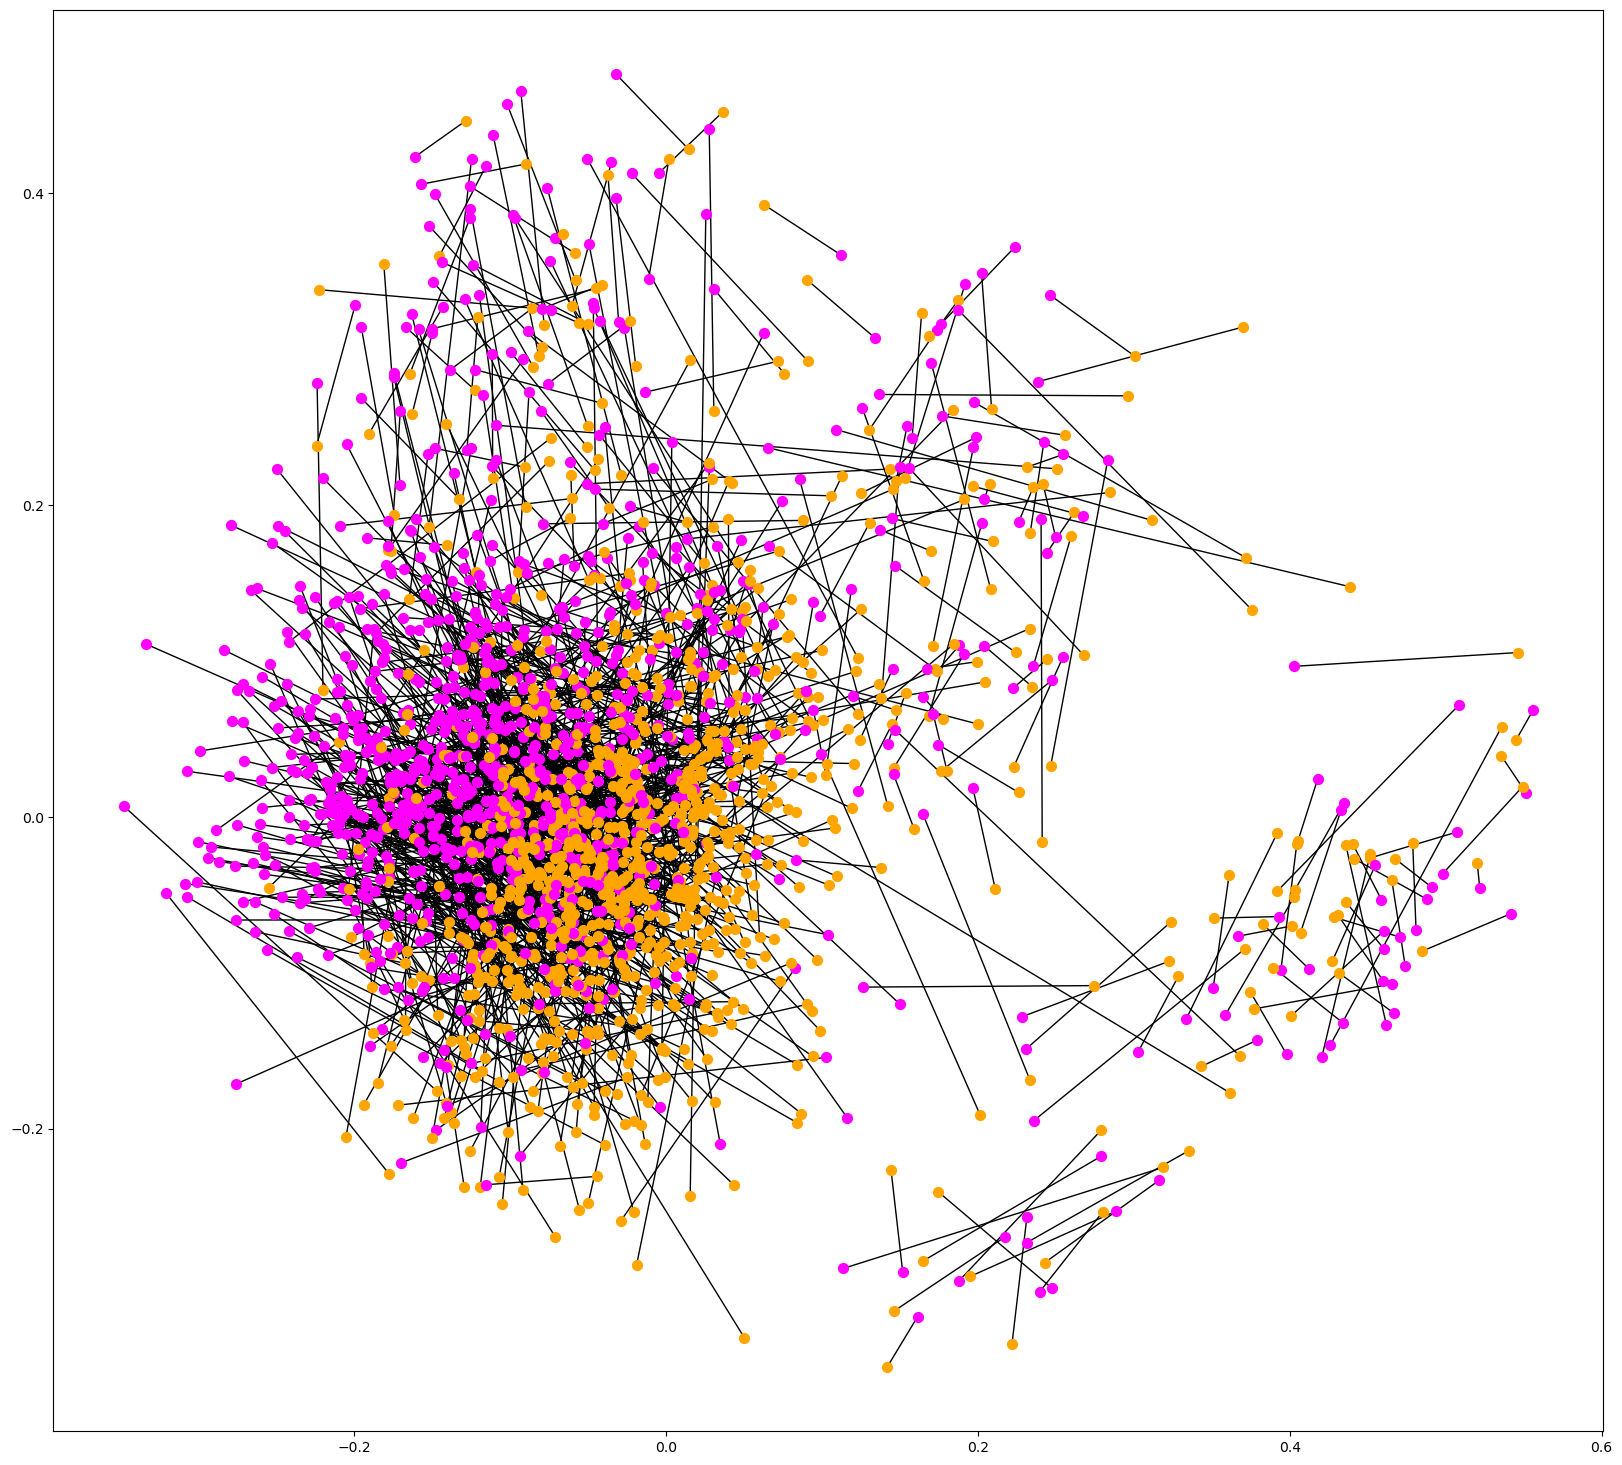

In [19]:
mask_df = coef_df[coef_df["ont_het"]=="ont"].reset_index()

linewidth=1
col="k"
al = 1
start_col = "magenta"
end_col = "orange"
ps=50

plt.figure(figsize=(20,20))

for i in range(len(mask_df)):
    
    if i%200==0:
        print(i)

    xAF = np.poly1d(np.array(mask_df.loc[i, ["xA_a","xA_b","xA_c"]]))
    xBF = np.poly1d(np.array(mask_df.loc[i, ["xB_a","xB_b","xB_c"]]))
    xCF = np.poly1d(np.array(mask_df.loc[i, ["xC_a","xC_b","xC_c"]]))
    xDF = np.poly1d(np.array(mask_df.loc[i, ["xD_a","xD_b","xD_c"]]))
    xEF = np.poly1d(np.array(mask_df.loc[i, ["xE_a","xE_b","xE_c"]]))
    xFF = np.poly1d(np.array(mask_df.loc[i, ["xF_a","xF_b","xF_c"]]))
    xGF = np.poly1d(np.array(mask_df.loc[i, ["xG_a","xG_b","xG_c"]]))
    xHF = np.poly1d(np.array(mask_df.loc[i, ["xH_a","xH_b","xH_c"]]))
    xIF = np.poly1d(np.array(mask_df.loc[i, ["xI_a","xI_b","xI_c"]]))
    xJF = np.poly1d(np.array(mask_df.loc[i, ["xJ_a","xJ_b","xJ_c"]]))
    xKF = np.poly1d(np.array(mask_df.loc[i, ["xK_a","xK_b","xK_c"]]))

    yAF = np.poly1d(np.array(mask_df.loc[i, ["yA_a","yA_b","yA_c"]]))
    yBF = np.poly1d(np.array(mask_df.loc[i, ["yB_a","yB_b","yB_c"]]))
    yCF = np.poly1d(np.array(mask_df.loc[i, ["yC_a","yC_b","yC_c"]]))
    yDF = np.poly1d(np.array(mask_df.loc[i, ["yD_a","yD_b","yD_c"]]))
    yEF = np.poly1d(np.array(mask_df.loc[i, ["yE_a","yE_b","yE_c"]]))
    yFF = np.poly1d(np.array(mask_df.loc[i, ["yF_a","yF_b","yF_c"]]))
    yGF = np.poly1d(np.array(mask_df.loc[i, ["yG_a","yG_b","yG_c"]]))
    yHF = np.poly1d(np.array(mask_df.loc[i, ["yH_a","yH_b","yH_c"]]))
    yIF = np.poly1d(np.array(mask_df.loc[i, ["yI_a","yI_b","yI_c"]]))
    yJF = np.poly1d(np.array(mask_df.loc[i, ["yJ_a","yJ_b","yJ_c"]]))
    yKF = np.poly1d(np.array(mask_df.loc[i, ["yK_a","yK_b","yK_c"]]))

    ## array for modeled start coordinate values
    p = 0
    modeled_start_vals = np.array(
        [[
        xAF(p), yAF(p),
        xBF(p), yBF(p),
        xCF(p), yCF(p),
        xDF(p), yDF(p),
        xEF(p), yEF(p),
        xFF(p), yFF(p),
        xGF(p), yGF(p),
        xHF(p), yHF(p),
        xIF(p), yIF(p),
        xJF(p), yJF(p),
        xKF(p), yKF(p)
        ]])
    #modeled_start_vals = np.reshape(modeled_start_vals, (1,-1))

    ## array for modeled end coordinate values
    q = 1
    modeled_end_vals = np.array(
        [[xAF(q), yAF(q),
        xBF(q), yBF(q),
        xCF(q), yCF(q),
        xDF(q), yDF(q),
        xEF(q), yEF(q),
        xFF(q), yFF(q),
        xGF(q), yGF(q),
        xHF(q), yHF(q),
        xIF(q), yIF(q),
        xJF(q), yJF(q),
        xKF(q), yKF(q)]])

    ## project start to get PC vals
    PC_start = pca.transform(modeled_start_vals)

    ## project end to get PC vals
    PC_end = pca.transform(modeled_end_vals)

    plt.plot(
        [PC_start[:,0], PC_end[:,0]],
        [PC_start[:,1], PC_end[:,1]],
        lw=linewidth,
        c=col,
        alpha=al
            )

    plt.scatter(PC_start[:,0], PC_start[:,1], c=start_col, zorder=4, s=ps)
    plt.scatter(PC_end[:,0], PC_end[:,1], c=end_col, zorder=4, s=ps)
    plt.gca().set_aspect("equal")

# Plot in PCA space base-to-middle line segments for heteroblasty

0
200
400
600
800
1000


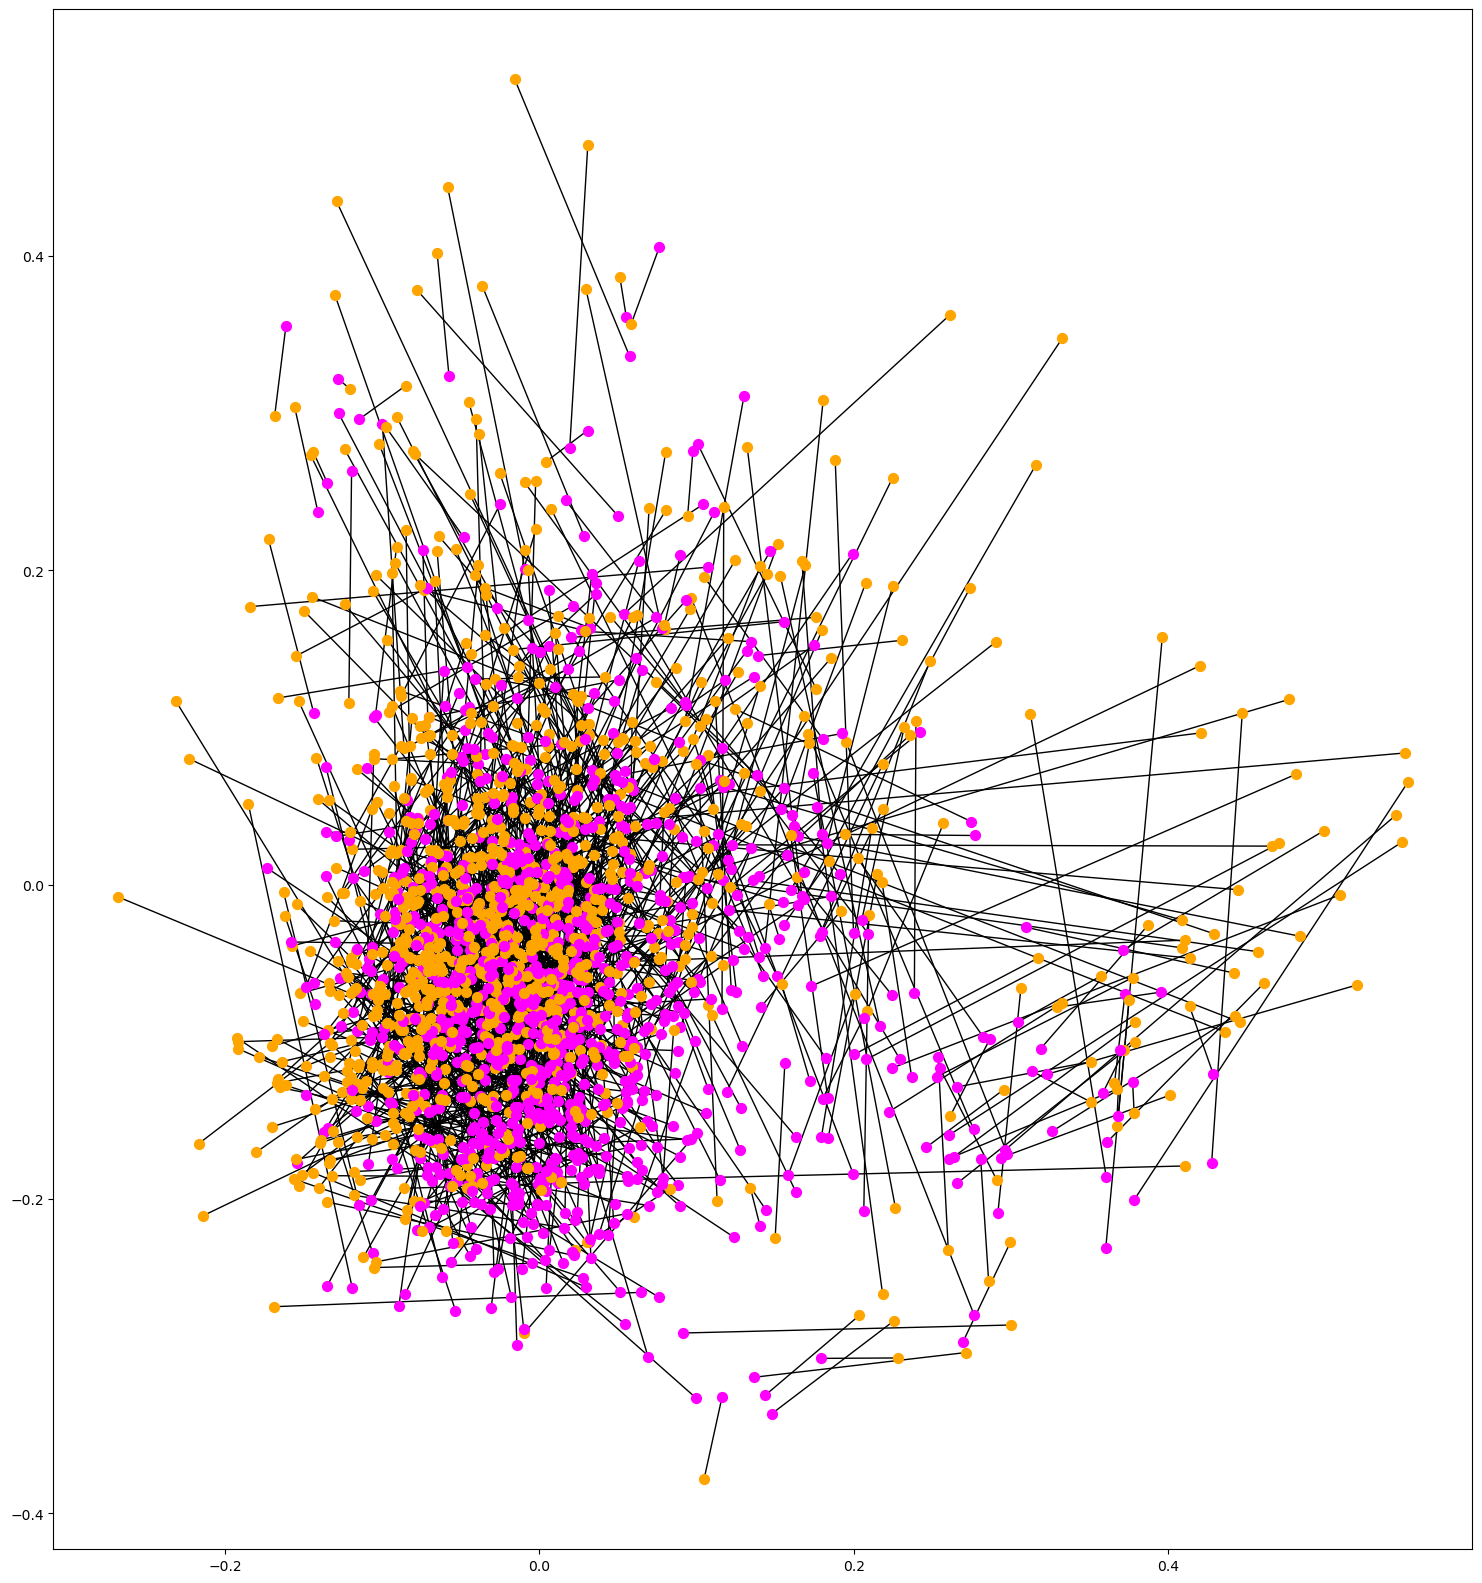

In [20]:
mask_df = coef_df[coef_df["ont_het"]=="het"].reset_index()

linewidth=1
col="k"
al = 1
start_col = "magenta"
end_col = "orange"
ps=50

plt.figure(figsize=(20,20))

for i in range(len(mask_df)):
    
    if i%200==0:
        print(i)

    xAF = np.poly1d(np.array(mask_df.loc[i, ["xA_a","xA_b","xA_c"]]))
    xBF = np.poly1d(np.array(mask_df.loc[i, ["xB_a","xB_b","xB_c"]]))
    xCF = np.poly1d(np.array(mask_df.loc[i, ["xC_a","xC_b","xC_c"]]))
    xDF = np.poly1d(np.array(mask_df.loc[i, ["xD_a","xD_b","xD_c"]]))
    xEF = np.poly1d(np.array(mask_df.loc[i, ["xE_a","xE_b","xE_c"]]))
    xFF = np.poly1d(np.array(mask_df.loc[i, ["xF_a","xF_b","xF_c"]]))
    xGF = np.poly1d(np.array(mask_df.loc[i, ["xG_a","xG_b","xG_c"]]))
    xHF = np.poly1d(np.array(mask_df.loc[i, ["xH_a","xH_b","xH_c"]]))
    xIF = np.poly1d(np.array(mask_df.loc[i, ["xI_a","xI_b","xI_c"]]))
    xJF = np.poly1d(np.array(mask_df.loc[i, ["xJ_a","xJ_b","xJ_c"]]))
    xKF = np.poly1d(np.array(mask_df.loc[i, ["xK_a","xK_b","xK_c"]]))

    yAF = np.poly1d(np.array(mask_df.loc[i, ["yA_a","yA_b","yA_c"]]))
    yBF = np.poly1d(np.array(mask_df.loc[i, ["yB_a","yB_b","yB_c"]]))
    yCF = np.poly1d(np.array(mask_df.loc[i, ["yC_a","yC_b","yC_c"]]))
    yDF = np.poly1d(np.array(mask_df.loc[i, ["yD_a","yD_b","yD_c"]]))
    yEF = np.poly1d(np.array(mask_df.loc[i, ["yE_a","yE_b","yE_c"]]))
    yFF = np.poly1d(np.array(mask_df.loc[i, ["yF_a","yF_b","yF_c"]]))
    yGF = np.poly1d(np.array(mask_df.loc[i, ["yG_a","yG_b","yG_c"]]))
    yHF = np.poly1d(np.array(mask_df.loc[i, ["yH_a","yH_b","yH_c"]]))
    yIF = np.poly1d(np.array(mask_df.loc[i, ["yI_a","yI_b","yI_c"]]))
    yJF = np.poly1d(np.array(mask_df.loc[i, ["yJ_a","yJ_b","yJ_c"]]))
    yKF = np.poly1d(np.array(mask_df.loc[i, ["yK_a","yK_b","yK_c"]]))

    ## array for modeled start coordinate values
    p = 0
    modeled_start_vals = np.array(
        [[
        xAF(p), yAF(p),
        xBF(p), yBF(p),
        xCF(p), yCF(p),
        xDF(p), yDF(p),
        xEF(p), yEF(p),
        xFF(p), yFF(p),
        xGF(p), yGF(p),
        xHF(p), yHF(p),
        xIF(p), yIF(p),
        xJF(p), yJF(p),
        xKF(p), yKF(p)
        ]])
    #modeled_start_vals = np.reshape(modeled_start_vals, (1,-1))

    ## array for modeled end coordinate values
    q = 1
    modeled_end_vals = np.array(
        [[xAF(q), yAF(q),
        xBF(q), yBF(q),
        xCF(q), yCF(q),
        xDF(q), yDF(q),
        xEF(q), yEF(q),
        xFF(q), yFF(q),
        xGF(q), yGF(q),
        xHF(q), yHF(q),
        xIF(q), yIF(q),
        xJF(q), yJF(q),
        xKF(q), yKF(q)]])

    ## project start to get PC vals
    PC_start = pca.transform(modeled_start_vals)

    ## project end to get PC vals
    PC_end = pca.transform(modeled_end_vals)

    plt.plot(
        [PC_start[:,0], PC_end[:,0]],
        [PC_start[:,1], PC_end[:,1]],
        lw=linewidth,
        c=col,
        alpha=al
            )

    plt.scatter(PC_start[:,0], PC_start[:,1], c=start_col, zorder=4, s=ps)
    plt.scatter(PC_end[:,0], PC_end[:,1], c=end_col, zorder=4, s=ps)
    plt.gca().set_aspect("equal")

# Create a PCA space based on coefficient values from the models

In [65]:
features = ["xA_a","xA_b","xA_c","yA_a","yA_b","yA_c",
             "xB_a","xB_b","xB_c","yB_a","yB_b","yB_c",
             "xC_a","xC_b","xC_c","yC_a","yC_b","yC_c",
             "xD_a","xD_b","xD_c","yD_a","yD_b","yD_c",
             "xE_a","xE_b","xE_c","yE_a","yE_b","yE_c",
             "xF_a","xF_b","xF_c","yF_a","yF_b","yF_c",
             "xG_a","xG_b","xG_c","yG_a","yG_b","yG_c",
             "xH_a","xH_b","xH_c","yH_a","yH_b","yH_c",
             "xI_a","xI_b","xI_c","yI_a","yI_b","yI_c",
             "xJ_a","xJ_b","xJ_c","yJ_a","yJ_b","yJ_c",
             "xK_a","xK_b","xK_c","yK_a","yK_b","yK_c"
            ]

# Separating out the features
x = coef_df.loc[:, features].values

# Separating out the target
y = coef_df.loc[:,['ont_het']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

[2.67071558e-01 1.30939704e-01 1.14874566e-01 7.38802943e-02
 6.02546674e-02 5.33616444e-02 4.38618833e-02 4.14969571e-02
 3.54195386e-02 3.01423910e-02 2.50027687e-02 2.44481942e-02
 2.08443698e-02 1.65191015e-02 1.34828939e-02 9.59660223e-03
 7.60555723e-03 5.64118753e-03 4.84941498e-03 4.12278809e-03
 3.47226724e-03 3.08276891e-03 2.74992842e-03 2.41890920e-03
 1.57420340e-03 1.08832763e-03 7.32304219e-04 4.22357789e-04
 3.21405378e-04 2.05861058e-04 1.90293160e-04 1.70709593e-04
 1.54580948e-04 8.78859495e-31 1.52306510e-31 1.44504849e-31
 1.13886621e-31 8.69961246e-32 7.84696267e-32 7.36615193e-32
 7.13763029e-32 5.83793444e-32 3.62326694e-32 3.01532852e-32
 2.25042913e-32 2.20165003e-32 1.80188048e-32 1.59624186e-32
 1.44193078e-32 1.40973742e-32 7.47856438e-33 7.02683290e-33
 6.67402479e-33 6.09209469e-33 3.58246423e-33 3.15804512e-33
 3.02531746e-33 2.95536395e-33 2.44353739e-33 2.42668676e-33
 1.65186152e-33 8.62314237e-34 5.35290988e-34 4.13974152e-34
 2.42149387e-34 6.135983

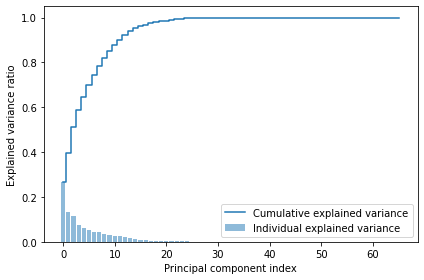

In [66]:
pca = PCA()
get_percents = pca.fit_transform(x)
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
print(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [67]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])

In [68]:
finalDf = pd.concat([principalDf, coef_df[['ont_het']], coef_df[['dataset']]   ],axis = 1)

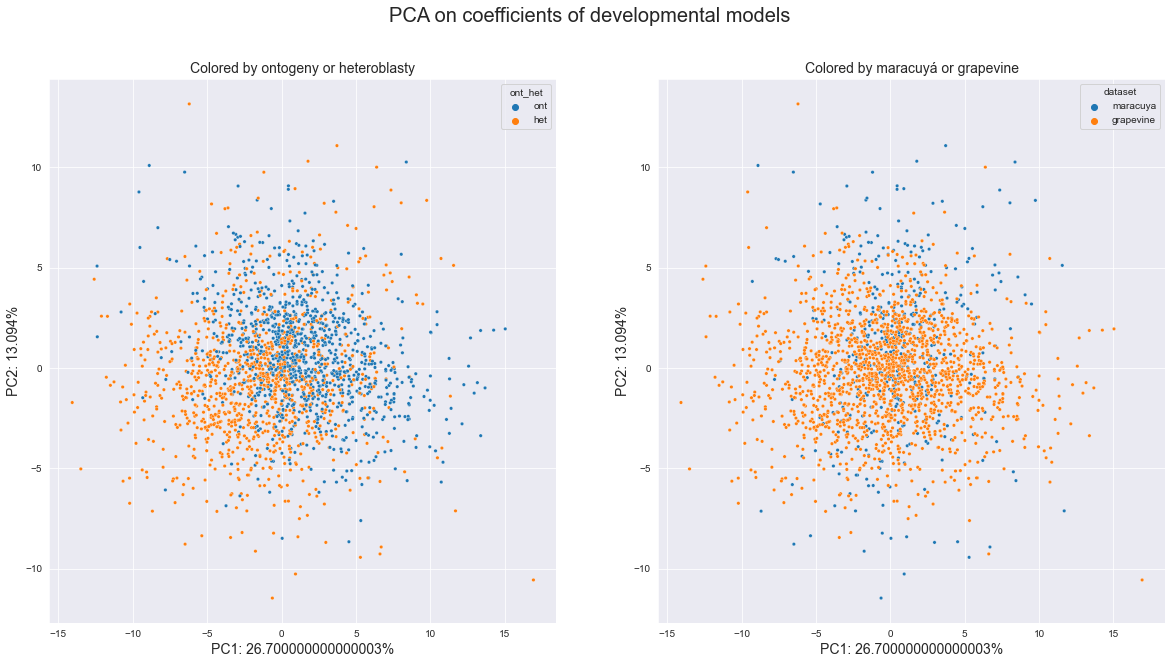

In [71]:
sns.set_style("darkgrid")
plt.figure(figsize=(20,10))

## fontsize
fs=14

## point size
ps = 12

## alpha
al = 1

plt.subplot(1,2,1)
sns.scatterplot(data=finalDf, x="PC1", y="PC2", hue="ont_het", alpha=al, s=ps)
plt.xlabel("PC1: "+ str( round(pca.explained_variance_ratio_[0],3)*100 ) + "%", fontsize=fs)
plt.ylabel("PC2: "+ str( round(pca.explained_variance_ratio_[1],5)*100 ) + "%", fontsize=fs)
plt.title("Colored by ontogeny or heteroblasty", fontsize=fs)

plt.subplot(1,2,2)
sns.scatterplot(data=finalDf, x="PC1", y="PC2", hue="dataset", alpha=al, s=ps)
plt.xlabel("PC1: "+ str( round(pca.explained_variance_ratio_[0],3)*100 ) + "%", fontsize=fs)
plt.ylabel("PC2: "+ str( round(pca.explained_variance_ratio_[1],5)*100 ) + "%", fontsize=fs)
plt.title("Colored by maracuyá or grapevine", fontsize=fs)

plt.suptitle("PCA on coefficients of developmental models", fontsize=fs+6)

plt.savefig("model_PCA.jpg")


# Create a Linear Discriminant Analysis (LDA) to discriminate ontogeny/heteroblasty

In [72]:
model = LinearDiscriminantAnalysis()
model.fit(x, y)

#Define method to evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)

#evaluate model
scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores))   

0.9233497209673132


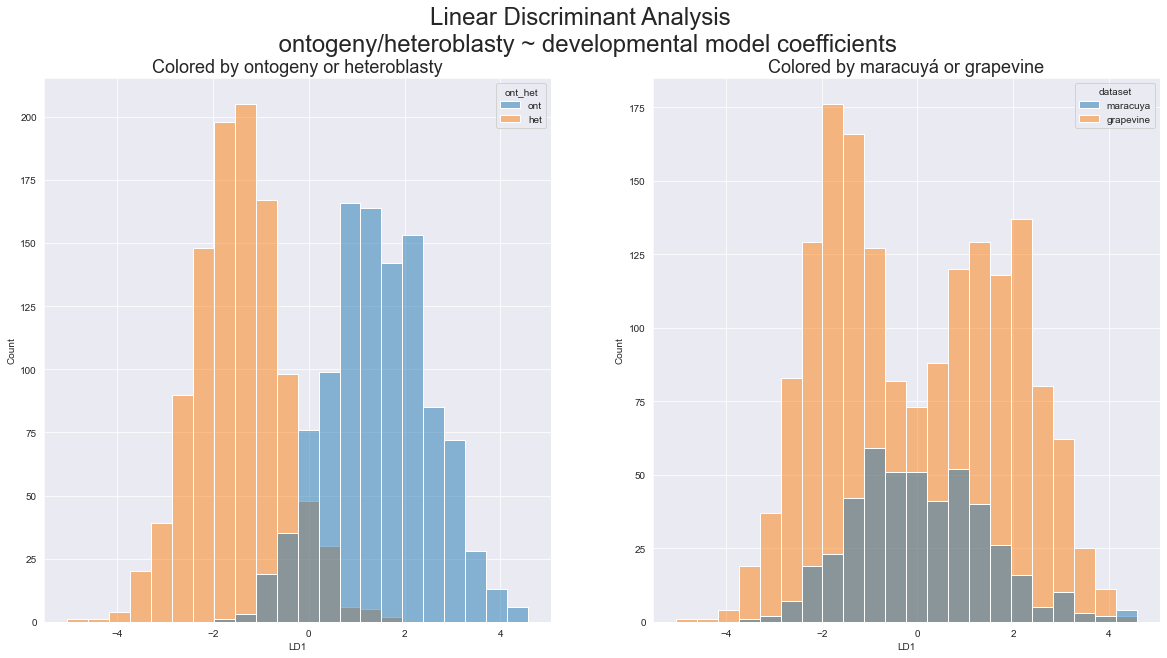

In [73]:
data_plot = np.reshape(model.fit(x, y).transform(x), (np.shape(model.fit(x, y).transform(x))[0]) )

LD_ont_het = np.array(coef_df["ont_het"])
LD_dataset = np.array(coef_df["dataset"])

LD_df = pd.DataFrame({'LD1':data_plot, 'ont_het':LD_ont_het, "dataset":LD_dataset})

#############################

sns.set_style("darkgrid")
plt.figure(figsize=(20,10))
fs = 18

plt.subplot(1,2,1)
sns.histplot(LD_df, x="LD1", hue="ont_het")
plt.title("Colored by ontogeny or heteroblasty", fontsize=fs)

plt.subplot(1,2,2)
sns.histplot(LD_df, x="LD1", hue="dataset")
plt.title("Colored by maracuyá or grapevine", fontsize=fs)

plt.suptitle("Linear Discriminant Analysis \n ontogeny/heteroblasty ~ developmental model coefficients", fontsize=fs+6)

plt.savefig("devmodel_LDA.jpg")


# Create a Linear Discriminant Analysis (LDA) to discriminate maracuyá/grapevine

In [74]:
# Separating out the features
x = coef_df.loc[:, features].values

# Separating out the target
dataset_y = coef_df.loc[:,['dataset']].values

model = LinearDiscriminantAnalysis()
model.fit(x, dataset_y)

#Define method to evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)

#evaluate model
scores = cross_val_score(model, x, dataset_y, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores))   

0.9840889361325184


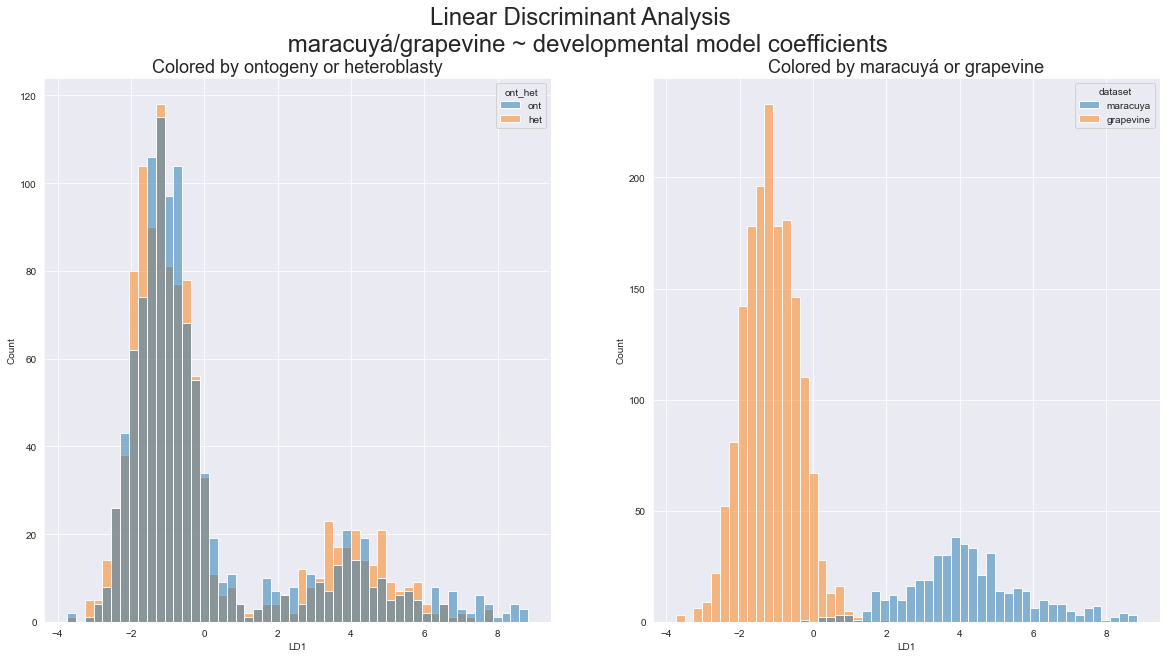

In [75]:
data_plot = np.reshape(model.fit(x, dataset_y).transform(x), (np.shape(model.fit(x, dataset_y).transform(x))[0]) )

LD_ont_het = np.array(coef_df["ont_het"])
LD_dataset = np.array(coef_df["dataset"])

LD_df = pd.DataFrame({'LD1':data_plot, 'ont_het':LD_ont_het, "dataset":LD_dataset})

#############################

sns.set_style("darkgrid")
plt.figure(figsize=(20,10))
fs = 18

plt.subplot(1,2,1)
sns.histplot(LD_df, x="LD1", hue="ont_het")
plt.title("Colored by ontogeny or heteroblasty", fontsize=fs)

plt.subplot(1,2,2)
sns.histplot(LD_df, x="LD1", hue="dataset")
plt.title("Colored by maracuyá or grapevine", fontsize=fs)

plt.suptitle("Linear Discriminant Analysis \n maracuyá/grapevine ~ developmental model coefficients", fontsize=fs+6)

plt.savefig("dataset_model_LDA.jpg")


# Create a Linear Discriminant Analysis (LDA) to discriminate maracuyá ont, maracuyá het, grapevine ont, grapevine het

In [76]:
# Separating out the features
x = coef_df.loc[:, features].values

# Separating out the target
interaction_y = coef_df.loc[:,['interaction']].values

model = LinearDiscriminantAnalysis()
model.fit(x, dataset_y)

#Define method to evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)

#evaluate model
scores = cross_val_score(model, x, interaction_y, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores))   

0.9304150057578172


In [80]:
interact_LDs = model.fit(x, interaction_y).transform(x)

LD_ont_het = np.array(coef_df["ont_het"])
LD_dataset = np.array(coef_df["dataset"])
LD_interaction = np.array(coef_df["interaction"])

LD_df = pd.DataFrame({'LD1':interact_LDs[:,0], 
                      'LD2':interact_LDs[:,1], 
                      'LD3':interact_LDs[:,2],
                      'ont_het':LD_ont_het, 
                      "dataset":LD_dataset, 
                      "interaction":LD_interaction})

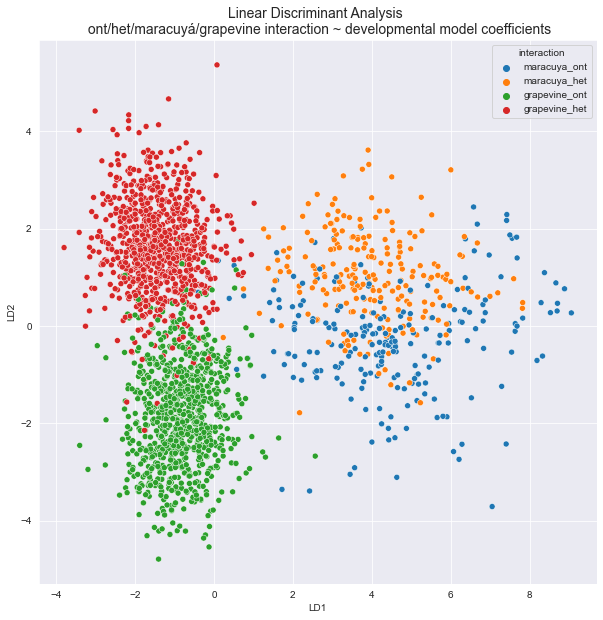

In [83]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=LD_df, x="LD1", y="LD2", hue="interaction")
plt.title("Linear Discriminant Analysis \n ont/het/maracuyá/grapevine interaction ~ developmental model coefficients", fontsize=14)
plt.savefig("interaction_LDA.jpg")
